# Fine-tune with a RidgeClassifier
Creates a model that combines pybioclip image embeddings with a RidgeClassifier using images from the [Somnath01/Birds_Species](https://huggingface.co/datasets/Somnath01/Birds_Species) dataset. This dataset contains 1000 train images, 403 test images, and 50 validation images. This notebook only uses the train and test images. This dataset was chosen for convenience. No analysis of the suitability of this dataset has been done.

When running this notebook in COLAB change the _runtime type_ to a GPU type to speed up processing. Additionally when running the next step in COLAB you you may see an error about the version of `fsspec` installed. This issue doesn't seem to cause any problem with this notebook.

In [1]:
!pip install -q numpy datasets pybioclip scikit-learn matplotlib

In [2]:
import itertools
import numpy as np
from tqdm.notebook import tqdm

import torch
from datasets import load_dataset

from bioclip.predict import BaseClassifier

import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.experimental.enable_halving_search_cv
import sklearn.linear_model
import scipy.stats
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
# Dataset settings
HF_DATASET_NAME = "Somnath01/Birds_Species"
TRAIN_NAME = 'train'
TEST_NAME = 'test'
IMAGE_NAME = 'image'
LABEL_NAME = 'label'

# Image embedding settings
BATCH_SIZE = 30

## Determine GPU or CPU

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## Load dataset
This step takes around 7 minutes to download the images the first time it is run.

In [5]:
dataset = load_dataset(HF_DATASET_NAME)
dataset

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/403 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 403
    })
})

Labels: ABBOTTS BABBLER,ABBOTTS BOOBY,ABYSSINIAN GROUND HORNBILL,AFRICAN CROWNED CRANE,AFRICAN EMERALD CUCKOO,AFRICAN FIREFINCH,AFRICAN OYSTER CATCHER,AFRICAN PIED HORNBILL,AFRICAN PYGMY GOOSE,ALBATROSS 

Example Image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x107706650>


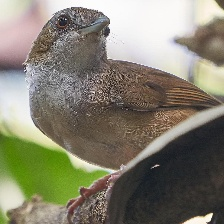

In [6]:
print("Labels:", ",".join(dataset[TRAIN_NAME].features[LABEL_NAME].names), "\n")
print("Example Image:", dataset[TRAIN_NAME][IMAGE_NAME][0])
dataset[TRAIN_NAME][IMAGE_NAME][0]

## Function to Convert PIL to image embeddings

In [7]:
classifier = BaseClassifier(device=device)

In [8]:
def batched(items, batch_size):
    it = iter(items)
    while (batch := list(itertools.islice(it, batch_size))):
          yield batch

In [9]:
def create_image_features(pil_image_ary):
    # batch PIL -> features transformation
    all_features = []
    with tqdm(total=len(pil_image_ary), desc='Creating image embeddings', unit='image') as progress_bar:
        for images in batched(pil_image_ary, BATCH_SIZE):
            features = classifier.create_image_features(images, normalize=True)
            all_features.append(features.cpu())
            progress_bar.update(len(images))
    return torch.cat(all_features, dim=0).cpu().numpy()

## Function to show prediction metrics

In [10]:
def show_metrics(expected_label_ary, predicted_label_ary):
    print("Accuracy:", round(accuracy_score(expected_label_ary, predicted_label_ary), 3))
    cm = confusion_matrix(expected_label_ary, predicted_label_ary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    disp.ax_.set_title("Confusion Matrix")
    plt.show()

## Setup a RidgeClassifier model
The `init_clf()` function is simplfied from [biobench plantnet](https://github.com/samuelstevens/biobench/blob/637432bfda2b567d966d49bf8c4b37b339d4dc2a/biobench/plantnet/__init__.py#L212C1-L228C6) 
created by [@samuelstevens](https://github.com/samuelstevens).

In [11]:
def init_clf():
    return sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(),
            sklearn.linear_model.RidgeClassifier(),
        )

In [12]:
# Create a model that preprocesses images into feature embeddings that are passed to the RidgeClassifier
model = sklearn.pipeline.make_pipeline(
    FunctionTransformer(create_image_features),
    init_clf(),
)

## Train the RidgeClassifier model
Trains the model using the train dataset. This step takes ~ 8 minutes when running on CPU and ~1 minute otherwise.

In [13]:
model.fit(dataset[TRAIN_NAME][IMAGE_NAME], dataset[TRAIN_NAME][LABEL_NAME])

Creating image embeddings:   0%|          | 0/1000 [00:00<?, ?image/s]

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function create_image_features at 0x3343a4ca0>)),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('ridgeclassifier', RidgeClassifier())]))])

## Create predictions
Predicts species for the test dataset. This step takes ~ 4 minutes when running on CPU and ~1 minute otherwise.

Creating image embeddings:   0%|          | 0/403 [00:00<?, ?image/s]

Accuracy: 0.99


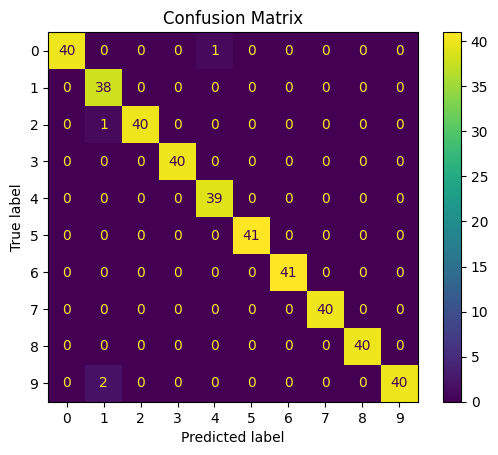

In [14]:
predicted_labels = model.predict(dataset[TEST_NAME][IMAGE_NAME])
show_metrics(predicted_labels, dataset[TEST_NAME][LABEL_NAME])

## Compare against untrained pybioclip model
This step takes ~ 6 minutes when running on CPU and ~1 minute otherwise.

Accuracy: 0.918


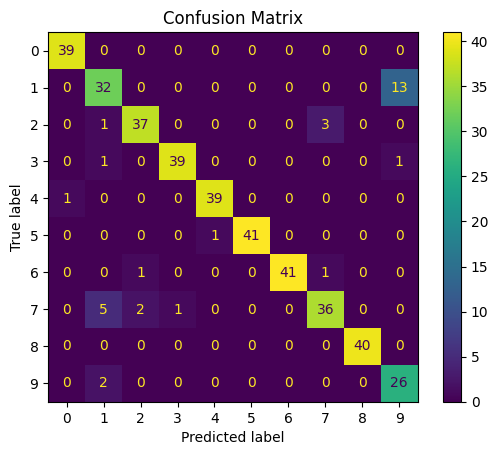

In [15]:
from bioclip.predict import CustomLabelsClassifier
classifier = CustomLabelsClassifier(dataset[TEST_NAME].features[LABEL_NAME].names, device=device)
predicted_labels = []
for images in batched(dataset[TEST_NAME][IMAGE_NAME], BATCH_SIZE):
    predictions = classifier.predict(images, k=1)
    for pred in predictions:
        label_str = pred['classification']
        label = dataset[TEST_NAME].features[LABEL_NAME].str2int(label_str)
        predicted_labels.append(label)
show_metrics(predicted_labels, dataset[TEST_NAME][LABEL_NAME])